# House Pricing
Studi kasus ini membahas proses eksplorasi data harga rumah, pembersihan data, persiapan data, pembangunan model prediktif, hingga evaluasi kinerja model.

Tujuan utama dari proyek ini adalah untuk memahami faktor-faktor yang memengaruhi harga rumah serta membandingkan performa dua model prediktif, yaitu Linear Regression dan Random Forest.

## Persiapan & Load Data
Menyiapkan library yang dibutuhkan

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Mengambil dataset yang tersedia dari house_prices.csv

In [16]:
df = pd.read_csv("housing_prices.csv")
df.head()

,house_size,num_rooms,distance_city_center,crime_rate,age_of_house,lot_size,region,price
0,148.534955,7.0,20.858647,NaN,12.340541,155.944221,West,-17139.403890
1,141.191404,3.0,8.184570,4.982501,21.140874,234.879653,East,-2934.233121
2,113.843035,7.0,14.347811,2.680021,26.207974,174.305494,South,17219.468820
3,118.759882,3.0,19.701043,2.403682,31.926722,234.757121,South,-29616.353070
4,109.864880,2.0,10.347340,3.251143,30.449713,108.020225,East,-22828.663460


## Data Understanding
Memahami data yang akan olah

In [17]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   house_size            968 non-null    float64
 1   num_rooms             976 non-null    float64
 2   distance_city_center  971 non-null    float64
 3   crime_rate            966 non-null    float64
 4   age_of_house          972 non-null    float64
 5   lot_size              968 non-null    float64
 6   region                974 non-null    object 
 7   price                 962 non-null    float64
dtypes: float64(7), object(1)
memory usage: 62.6+ KB


,house_size,num_rooms,distance_city_center,crime_rate,age_of_house,lot_size,price
count,968.000000,976.000000,971.000000,966.000000,972.000000,968.000000,962.000000
mean,120.127451,4.623610,16.051641,5.020276,20.429959,200.380385,-7073.627343
std,36.087615,2.083317,10.215622,2.490175,12.225763,59.487765,62302.291042
min,30.000000,2.000000,1.070739,0.000000,0.000000,51.280022,-177662.351900
25%,99.789401,3.000000,8.262834,3.575544,13.157173,166.468639,-46305.674087
50%,118.130910,5.000000,16.141064,4.882187,19.853876,199.124178,-10250.211890
75%,138.375099,6.000000,22.597426,6.288880,26.887857,228.529570,28268.186582
max,412.482114,21.528598,98.717486,25.195300,119.379754,683.281295,497102.320500


Data yang dianalisis merupakan hasil evaluasi sebuah model prediksi harga rumah, yang terdiri dari 1000 entri dengan berbagai fitur seperti luas bangunan dan jumlah kamar. Kolom price dalam data ini bukanlah harga jual properti, melainkan representasi dari error atau selisih prediksi, yang terbukti dengan adanya nilai negatif. Saat divisualisasikan, distribusi error ini membentuk sebuah histogram yang condong ke kanan (right-skewed), yang mengindikasikan bahwa meskipun model seringkali akurat untuk properti standar, ia memiliki kelemahan sistematis dalam menebak harga properti yang sangat mahal, di mana prediksinya cenderung jauh lebih rendah dari harga sebenarnya.

## Data Screening & Data Validation
Transformasi data region dari non-numerikal ke numerikal

In [18]:
region_mapping = {'West': 1, 'East': 2, 'South': 3, 'North': 4}
df['region_normalized'] = df['region'].map(region_mapping)

display(df[['region', 'region_normalized']].head())
df = df.drop('region', axis=1)

,region,region_normalized
0,West,1.0
1,East,2.0
2,South,3.0
3,South,3.0
4,East,2.0


Pemetaan dibuat untuk mengubah setiap nama wilayah (seperti 'West', 'East') menjadi angka unik (1, 2, dst.). Aturan ini kemudian diterapkan untuk membuat kolom baru bernama region_normalized yang berisi versi angka dari wilayah tersebut. Setelah konversi berhasil, seperti yang terlihat pada tabel output, kolom region yang asli dan berbasis teks dihapus, sehingga hanya menyisakan data numerik yang siap digunakan untuk analisis atau model machine learning.

**Cek Missing Value**

In [19]:
df.isnull().sum()

,0
house_size,32
num_rooms,24
distance_city_center,29
crime_rate,34
age_of_house,28
lot_size,32
price,38
region_normalized,26


Dari output, kita bisa melihat bahwa setiap kolom memiliki sejumlah data yang hilang. Misalnya, kolom house_size memiliki 32 data kosong, num_rooms memiliki 24, dan crime_rate memiliki 34. Kolom price adalah yang paling banyak kehilangan data, yaitu sebanyak 38 entri. Informasi ini sangat penting dalam tahap pembersihan data (data cleaning), karena kita perlu memutuskan cara menangani nilai-nilai yang hilang ini—apakah dengan menghapusnya atau mengisinya dengan nilai lain—sebelum data dapat digunakan untuk analisis lebih lanjut.

**Menangani Missing Value dengan Median**

Untuk data properti yang kita miliki, yang mungkin memiliki rumah dengan harga sangat mahal (outlier) dan distribusinya terbukti miring, menggunakan median adalah pendekatan yang lebih aman dan akurat untuk mengisi nilai yang hilang karena memberikan representasi yang lebih realistis dari titik pusat data.

In [20]:
for col in df.select_dtypes(include=np.number).columns:
    df[col] = df[col].fillna(df[col].median())

df.isnull().sum()

,0
house_size,0
num_rooms,0
distance_city_center,0
crime_rate,0
age_of_house,0
lot_size,0
price,0
region_normalized,0


Tabel mengatakan bahwa data sudah terisi semua

**Visualisasi variabel boxplot untuk menemukan data Outlier**

Boxplot sangat efektif untuk mendeteksi outlier karena ia secara visual memisahkan data normal dari data ekstrem menggunakan aturan statistik yang jelas. Grafik ini merangkum sebaran data di dalam sebuah "kotak" yang berisi 50% data inti dan memperluas "kumis" (whiskers) untuk menandai rentang data yang wajar. Setiap titik data yang jatuh di luar jangkauan kumis ini—biasanya yang berjarak lebih dari 1.5 kali rentang interkuartil (IQR) dari kotak—secara otomatis diidentifikasi sebagai outlier, sehingga kita bisa dengan cepat melihat nilai-nilai anomali dalam dataset.

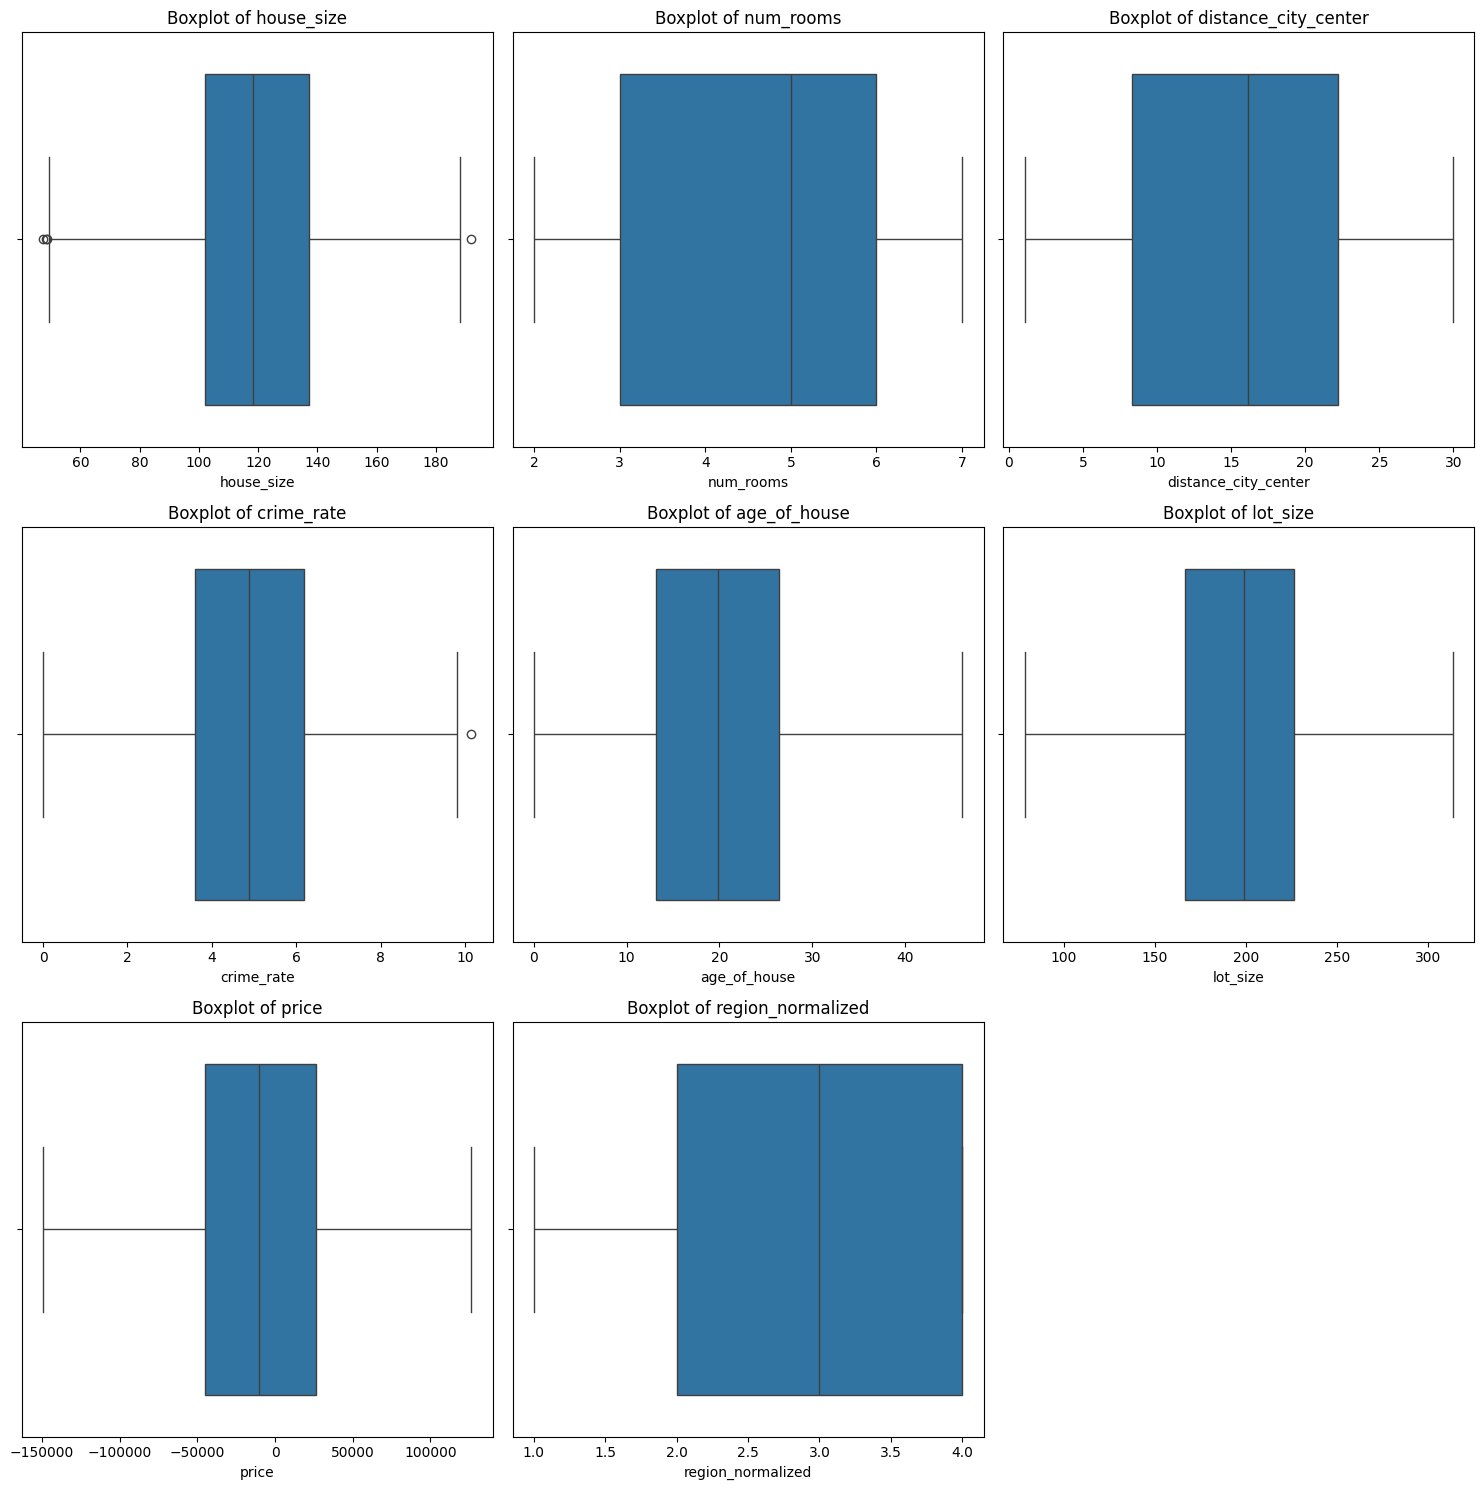

In [24]:
def plot_boxplots(df, numerical_cols):
    n_cols = 3
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

    plt.figure(figsize=(15, n_rows * 5))

    for i, col in enumerate(numerical_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot of {col}")

    plt.tight_layout()
    plt.show()

numerical_cols = ['house_size','num_rooms','distance_city_center','crime_rate','age_of_house','lot_size','price','region_normalized']
plot_boxplots(df, numerical_cols)

Kolom dengan Outlier Jelas
- price: Ini adalah kolom dengan outlier paling signifikan dan banyak, baik di sisi negatif (model menebak terlalu tinggi) maupun positif (model menebak terlalu rendah). Ini menunjukkan ada beberapa properti di mana model membuat kesalahan prediksi yang sangat besar.
- house_size: Terdapat beberapa outlier yang menunjukkan adanya rumah dengan ukuran jauh lebih besar atau lebih kecil dari mayoritas data.
- age_of_house: Terlihat ada outlier di sisi kanan, yang berarti ada satu atau beberapa rumah yang usianya jauh lebih tua dibandingkan rumah-rumah lainnya dalam dataset.
- crime_rate dan num_rooms: Juga menunjukkan adanya beberapa outlier, meskipun tidak seekstrem pada kolom price.

Kolom Tanpa Outlier Signifikan
- distance_city_center dan lot_size: Kedua fitur ini memiliki distribusi yang relatif bersih. Hampir semua titik data berada dalam rentang wajar yang ditentukan oleh kumis boxplot, sehingga tidak ada outlier yang mencolok.
- region_normalized: Sebagai data kategorikal yang dinumerisasi, wajar jika tidak ada outlier karena nilainya terbatas pada kategori yang ada (1, 2, 3, 4).

**Tangani outlier dengan metode IQR**

In [29]:
for col in ['house_size','num_rooms','distance_city_center','crime_rate','age_of_house','lot_size','price']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df = df[(df[col] > lower) & (df[col] < upper)]

Pengecekan ulang

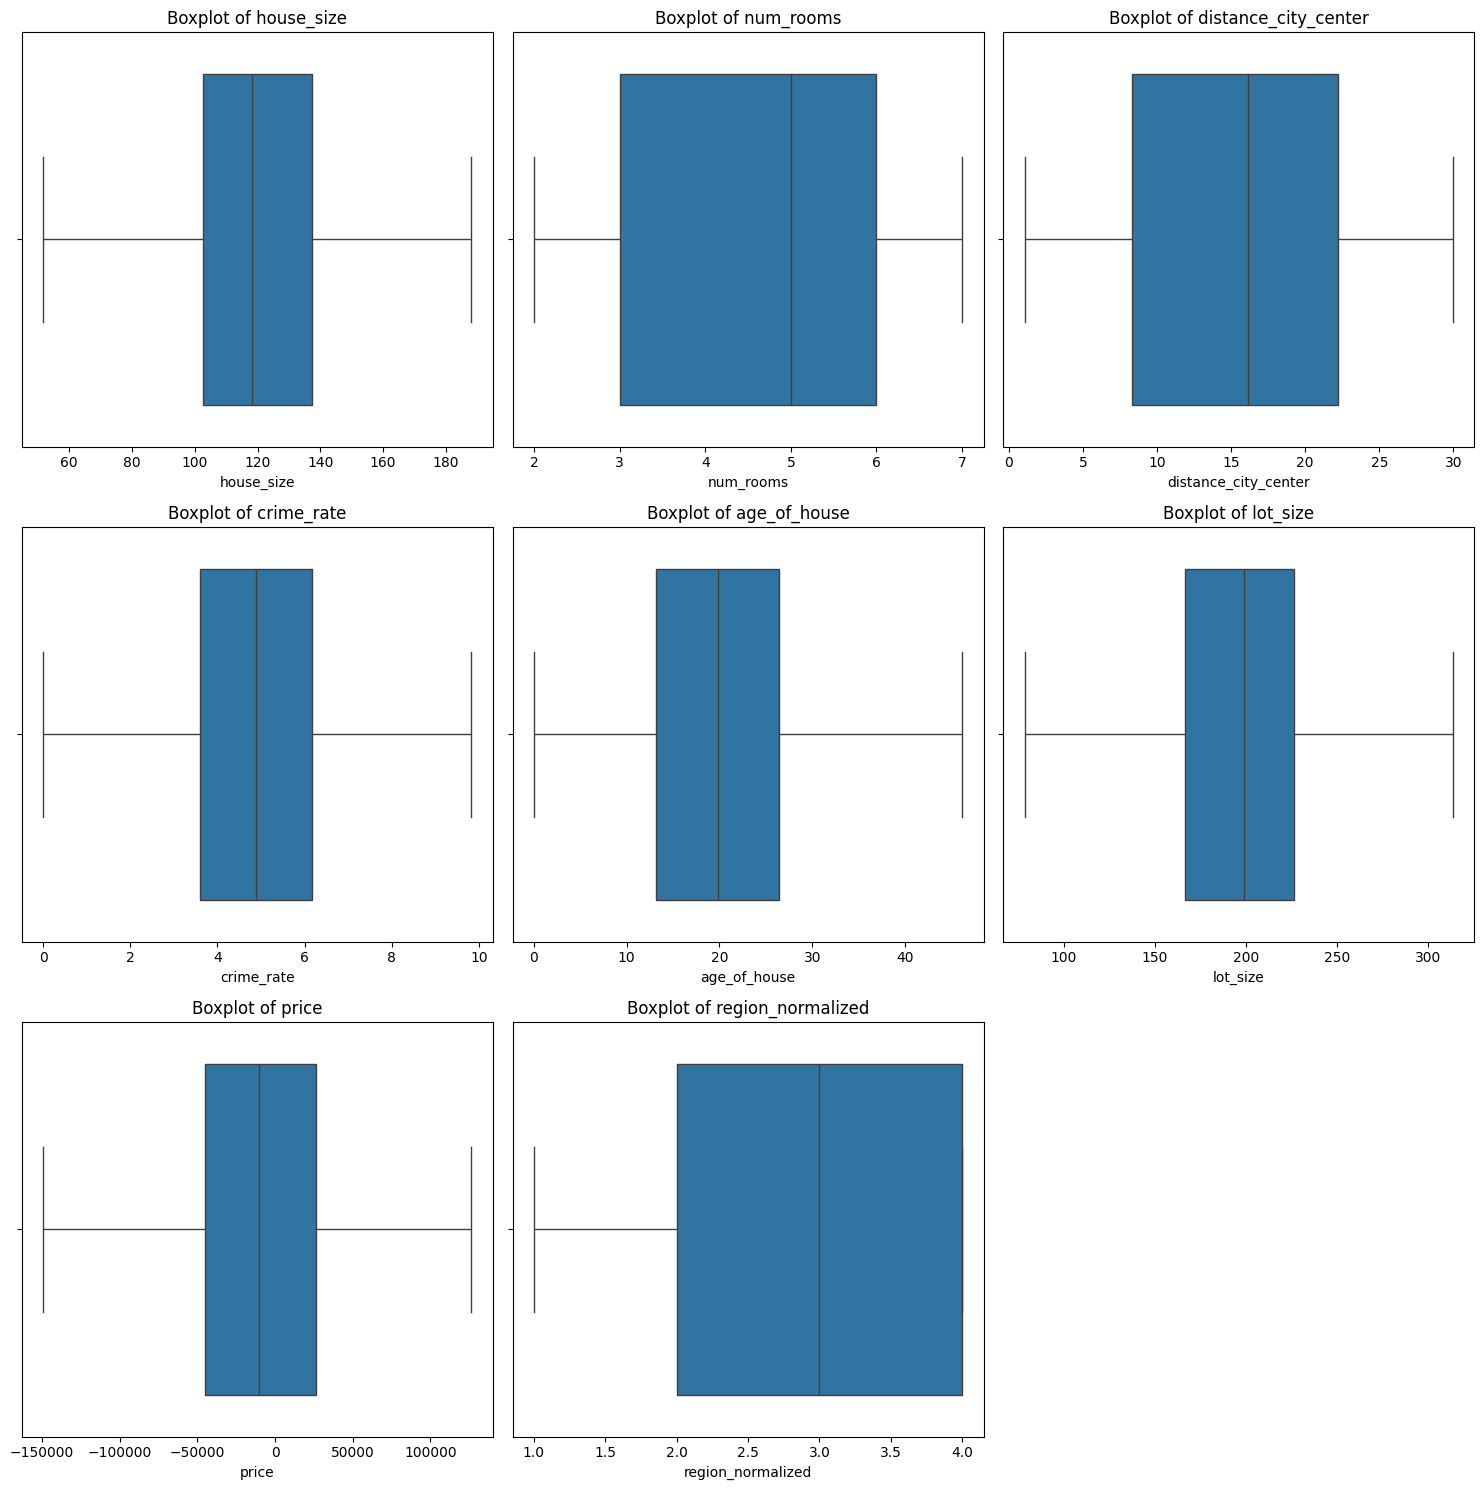

In [30]:
plot_boxplots(df, numerical_cols)

Terlihat bahwa data outlier sudah hilang

**Kolerasi Antar Variabel**

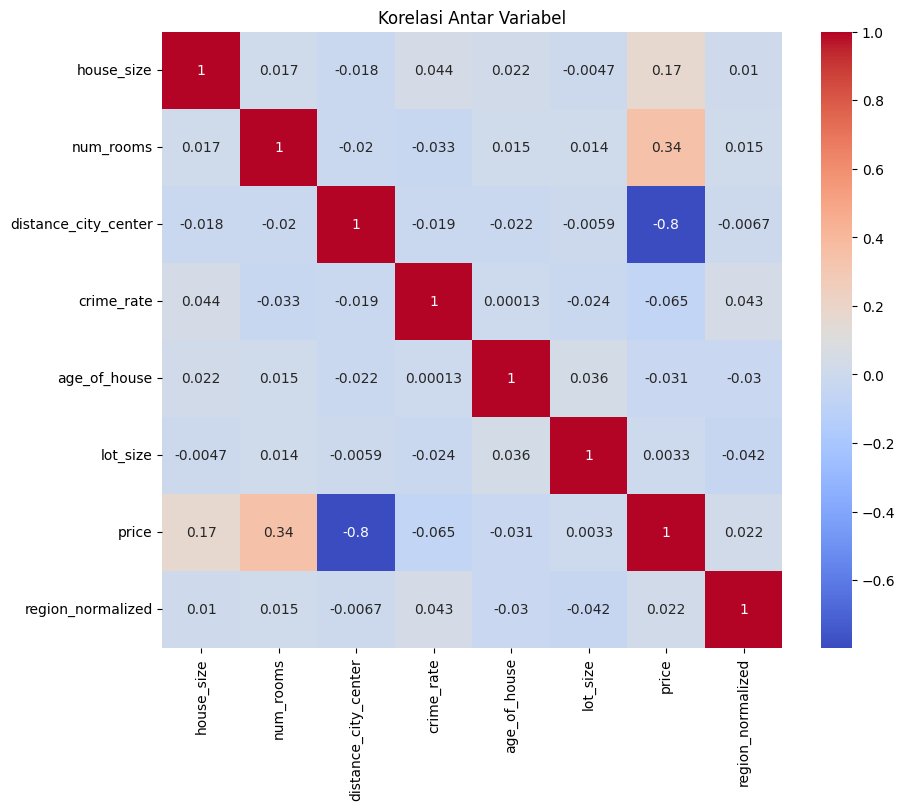

In [32]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Korelasi Antar Variabel')
plt.show()

- Harga rumah paling dipengaruhi oleh jarak ke pusat kota (semakin jauh, semakin murah).
- Jumlah ruangan dan ukuran rumah juga menaikkan harga, meski pengaruhnya lebih kecil.
- Faktor lain (usia rumah, tingkat kriminalitas, luas tanah) hampir tidak berpengaruh.

**Penilaian Validasi Data**

Berdasarkan langkah-langkah eksplorasi dan pembersihan data yang telah dilakukan:

1. **Missing Values:** Nilai yang hilang pada semua kolom numerik dan kolom `region` berhasil ditangani dengan imputasi menggunakan nilai median. Ini membantu memastikan bahwa dataset lengkap untuk pemodelan.

2. **Outliers:** Outlier pada kolom numerik ditangani menggunakan metode IQR, yang mengurangi jumlah titik data dari 1000 menjadi 928. Meskipun penghapusan outlier terkadang dapat menyebabkan hilangnya informasi, dalam kasus ini, hal ini membantu mengatasi nilai-nilai ekstrem yang dapat berdampak negatif pada kinerja model, terutama pada kolom `price` yang memiliki nilai negatif dan nilai yang sangat tinggi.

3. **Relevansi Fitur:** Analisis korelasi menunjukkan bahwa `distance_city_center`, `num_rooms`, dan `house_size` memiliki korelasi paling signifikan dengan `price`. Ini menunjukkan bahwa fitur-fitur ini kemungkinan merupakan prediktor yang baik untuk harga rumah dan dapat digunakan dalam model. Fitur lain seperti `age_of_house`, `crime_rate`, dan `lot_size` menunjukkan korelasi yang sangat rendah dengan harga, menunjukkan bahwa fitur-fitur tersebut mungkin kurang penting untuk prediksi dalam dataset ini.

**Kesimpulan:**

Data telah melalui proses pembersihan dan pra-pemrosesan yang signifikan (menangani missing values dan outliers). Fitur-fitur yang tersisa menunjukkan korelasi yang wajar dengan variabel target (`price`).

Oleh karena itu, data ini **cukup layak** untuk membangun model prediktif seperti Regresi Linier dan Random Forest, seperti yang ditunjukkan pada langkah pemodelan selanjutnya. Namun, penting untuk dicatat bahwa korelasi yang rendah dari beberapa fitur dapat membatasi kekuatan prediktif model jika fitur-fitur tersebut diharapkan signifikan berdasarkan pengetahuan domain. Rekayasa fitur (feature engineering) atau pemilihan fitur lebih lanjut berpotensi meningkatkan kinerja model.

## Modeling
Dalam proses pemodelan ini, kami menerapkan dua algoritma yang berbeda, yaitu Regresi Linear dan Random Forest, untuk mengevaluasi dan membandingkan performa masing-masing dalam memprediksi hasil.

**Regresi Linear:**

Digunakan karena kesederhanaan dan kemudahan interpretasinya (interpretability). Model ini sangat cepat dan bagus untuk memahami hubungan linear sederhana antara fitur dan target. Ia berfungsi sebagai baseline yang solid untuk melihat seberapa besar pengaruh setiap fitur secara individual.

**Random Forest:**

Digunakan untuk mendapatkan akurasi prediksi yang tinggi dan menangani hubungan yang kompleks. Model ini adalah ensemble dari banyak decision tree, sehingga mampu menangkap pola non-linear yang rumit dalam data dan lebih tahan terhadap overfitting dibandingkan satu decision tree tunggal.

Sebelum itu, membagi dataset menjadi dua bagian: data latih (training data) dan data uji (testing data). Tujuannya adalah untuk melatih model pada sebagian besar data, dan kemudian menguji seberapa baik performanya pada data yang belum pernah "dilihat" sebelumnya.

In [53]:
# Tentukan X (independen) dan y (dependen)
X = df.drop('price', axis=1)
y = df['price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
X_train.shape, X_test.shape

((828, 7), (92, 7))

Data shape tersebut menjukkan rasio 90:10

**Model Linear Regression**

In [54]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

**Model Random Forest**

In [55]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

## Evaluasi

Untuk mengevaluasi dan membandingkan secara objektif performa dari model Regresi Linear dan Random Forest, kami menggunakan tiga metrik evaluasi standar: Mean Absolute Error (MAE), Root Mean Square Error (RMSE), dan R-squared (R²).

MAE dihitung dengan mengambil selisih absolut (tanpa nilai negatif) antara setiap nilai prediksi dan nilai aktualnya, lalu merata-ratakan semua selisih tersebut. Metrik ini memberikan gambaran rata-rata seberapa besar kesalahan prediksi model dalam satuan yang sama dengan data aslinya, sehingga mudah diinterpretasikan.

Selanjutnya, RMSE dihitung dengan cara mengkuadratkan selisih antara nilai prediksi dan aktual, merata-ratakan hasil kuadrat tersebut, lalu mengambil akar kuadrat dari rata-rata itu. Dengan mengkuadratkan error, RMSE memberikan "hukuman" yang lebih besar pada kesalahan-kesalahan prediksi yang jauh melenceng, sehingga sangat sensitif terhadap outlier atau prediksi yang sangat buruk.

Terakhir, R-squared (R²) atau koefisien determinasi mengukur seberapa baik fitur-fitur dalam model dapat menjelaskan variasi pada data target. Dengan nilai berkisar antara 0 hingga 1, R² menunjukkan persentase variabilitas target yang berhasil ditangkap oleh model; semakin mendekati 1, semakin baik model tersebut dalam menjelaskan data.

In [56]:
def eval_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"Model: {model_name}")
    print(f"MAE : {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2  : {r2:.2f}\n")

eval_model(y_test, y_pred_lr, "Linear Regression")
eval_model(y_test, y_pred_rf, "Random Forest")

Model: Linear Regression
MAE : 16605.23
RMSE: 20717.55
R2  : 0.80

Model: Random Forest
MAE : 17279.97
RMSE: 21717.81
R2  : 0.78



Berdasarkan hasil evaluasi, model Regresi Linear menunjukkan performa yang lebih baik dibandingkan model Random Forest pada dataset ini.

- Kesalahan Prediksi (MAE & RMSE)
Regresi Linear memiliki nilai MAE dan RMSE yang lebih rendah. Ini berarti, secara rata-rata, prediksi yang dihasilkan oleh Regresi Linear lebih mendekati nilai aktual dibandingkan prediksi dari Random Forest.

- Kemampuan Menjelaskan Data (R²)
Regresi Linear memiliki skor R-squared yang lebih tinggi (0.8 vs 0.78). Artinya, model ini mampu menjelaskan 80% variabilitas data, sementara Random Forest hanya 78%.

**Grafik Perbandingan Prediksi vs Aktual dari Kedua Model**

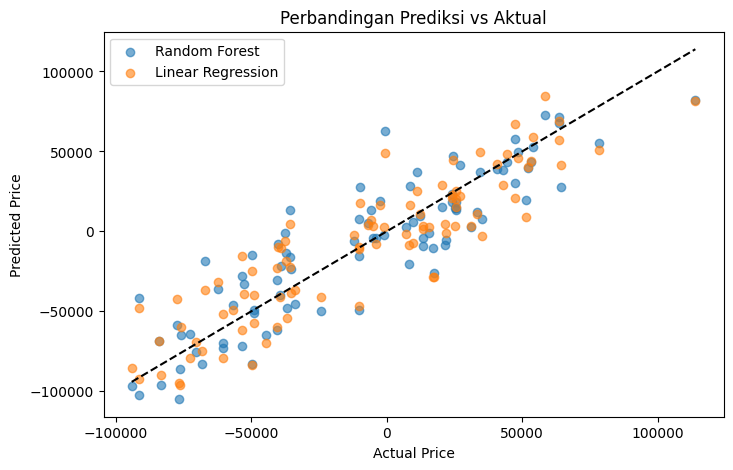

In [58]:
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred_rf, alpha=0.6, label="Random Forest")
plt.scatter(y_test, y_pred_lr, alpha=0.6, label="Linear Regression")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Perbandingan Prediksi vs Aktual")
plt.legend()
plt.show()

## Kesimpulan



Berdasarkan hasil eksplorasi dan pemodelan data harga rumah, diperoleh beberapa temuan penting:

- Faktor utama yang memengaruhi harga rumah adalah **jarak ke pusat kota** (berpengaruh negatif), **jumlah ruangan**, dan **ukuran rumah** (berpengaruh positif). Sementara itu, usia rumah, tingkat kriminalitas, serta luas tanah memiliki pengaruh yang relatif kecil.
- Proses pembersihan data melalui imputasi missing values dan penghapusan outlier berhasil meningkatkan kualitas data sehingga lebih siap digunakan untuk pemodelan.
- Dua model prediktif digunakan, yaitu Linear Regression dan Random Forest.
  - Linear Regression memberikan hasil lebih baik dengan MAE = 16605.23, RMSE = 20717.55, dan R² = 0.8.
  - Random Forest memiliki performa sedikit lebih rendah dengan MAE = 17279.97, RMSE = 21717.81, dan R² = 0.78.
  - Model Linear Regression lebih sesuai untuk kasus ini karena hubungan antar variabel cenderung linear, sehingga model sederhana dapat memberikan akurasi prediksi yang lebih baik dibandingkan Random Forest.